In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import timedelta
from mlxtend.frequent_patterns import apriori, association_rules
import os, warnings

os.environ["PYTHONWARNINGS"] = "ignore"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="mlxtend")
pd.options.mode.chained_assignment = None


# Data Preparation & Exploratory Data Analysis

In [115]:
# Data Overview
superstore_df_raw = pd.read_csv('Sample - Superstore.csv', encoding="latin1")
print(superstore_df_raw.shape)
print(superstore_df_raw.columns)
superstore_df_raw.head(3)

(9994, 21)
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [116]:
superstore_df_raw["Order Date"] = pd.to_datetime(superstore_df_raw["Order Date"])
superstore_df_raw["Ship Date"] = pd.to_datetime(superstore_df_raw["Ship Date"])

# Create calculated fields
superstore_df_raw["Profit Margin"] = superstore_df_raw["Profit"] / superstore_df_raw["Sales"]
superstore_df_raw["Delivery Days"] = (superstore_df_raw["Ship Date"] - superstore_df_raw["Order Date"]).dt.days
superstore_df_raw['Order Month'] = superstore_df_raw["Order Date"].dt.month

superstore_df_raw.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Profit Margin,Delivery Days,Order Month
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,0.16,3,11
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,0.30,3,11
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714,0.47,4,6


In [117]:
superstore_df_raw[["Sales", "Profit", "Discount", "Quantity", "Profit Margin", "Delivery Days"]].describe()


,Sales,Profit,Discount,Quantity,Profit Margin,Delivery Days
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,28.656896,0.156203,3.789574,0.120314,3.958175
std,623.245101,234.260108,0.206452,2.225110,0.466754,1.747567
min,0.444000,-6599.978000,0.000000,1.000000,-2.750000,0.000000
25%,17.280000,1.728750,0.000000,2.000000,0.075000,3.000000
50%,54.490000,8.666500,0.200000,3.000000,0.270000,4.000000
75%,209.940000,29.364000,0.200000,5.000000,0.362500,5.000000
max,22638.480000,8399.976000,0.800000,14.000000,0.500000,7.000000


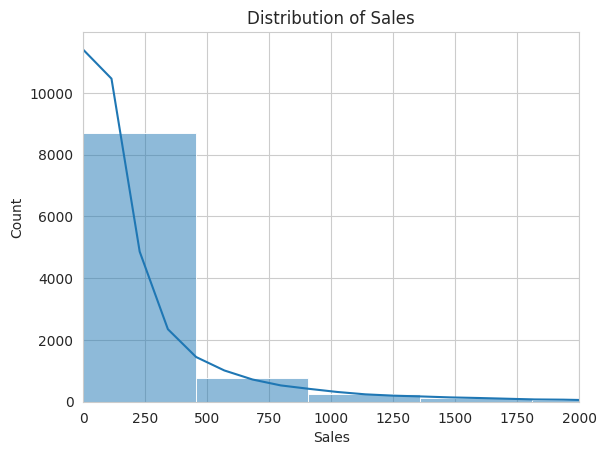

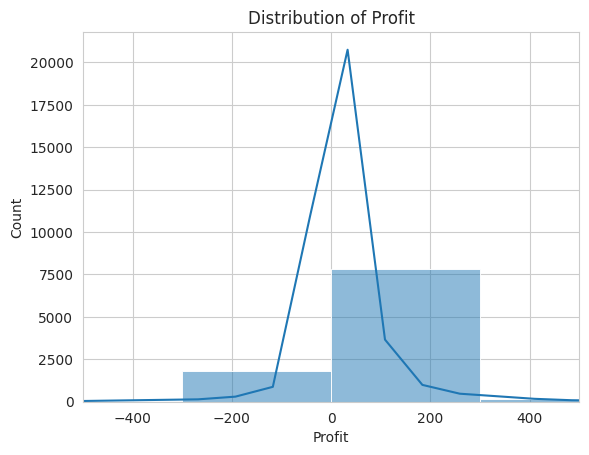

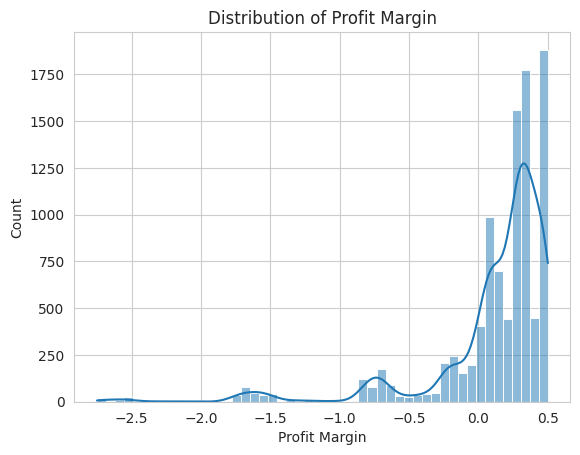

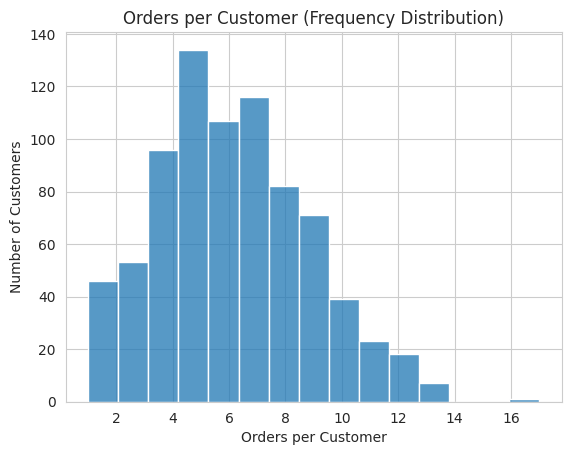

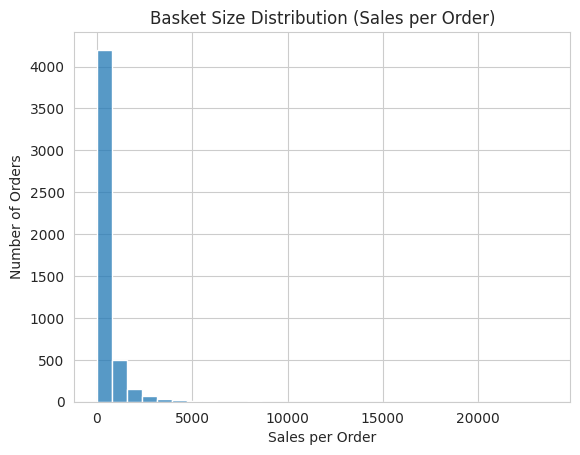

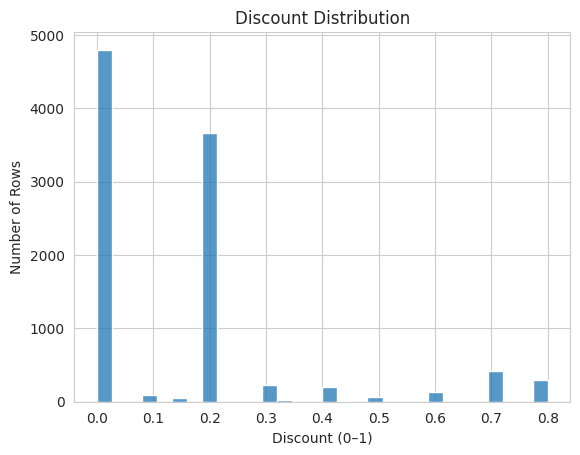

In [118]:
# Sales distribution
sns.histplot(superstore_df_raw["Sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlim(0, 2000)
plt.show()

# Profit distribution
sns.histplot(superstore_df_raw["Profit"], bins=50, kde=True)
plt.title("Distribution of Profit")
plt.xlim(-500, 500)
plt.show()

# Profit margin distribution
sns.histplot(superstore_df_raw["Profit Margin"], bins=50, kde=True)
plt.title("Distribution of Profit Margin")
plt.show()

# Orders per Customer (Frequency Distribution)
orders_per_customer = superstore_df_raw.groupby("Customer ID")["Order ID"].nunique()
sns.histplot(orders_per_customer, bins=15, kde=False)
plt.title("Orders per Customer (Frequency Distribution)")
plt.xlabel("Orders per Customer")
plt.ylabel("Number of Customers")
plt.show()

# Basket Size (Sales per Order)
sales_per_order = superstore_df_raw.groupby("Order ID")["Sales"].sum()
sns.histplot(sales_per_order, bins=30, kde=False)
plt.title("Basket Size Distribution (Sales per Order)")
plt.xlabel("Sales per Order")
plt.ylabel("Number of Orders")
plt.show()

# Discount Distribution
sns.histplot(superstore_df_raw["Discount"].dropna(), bins=30, kde=False)
plt.title("Discount Distribution")
plt.xlabel("Discount (0–1)")
plt.ylabel("Number of Rows")
plt.show()




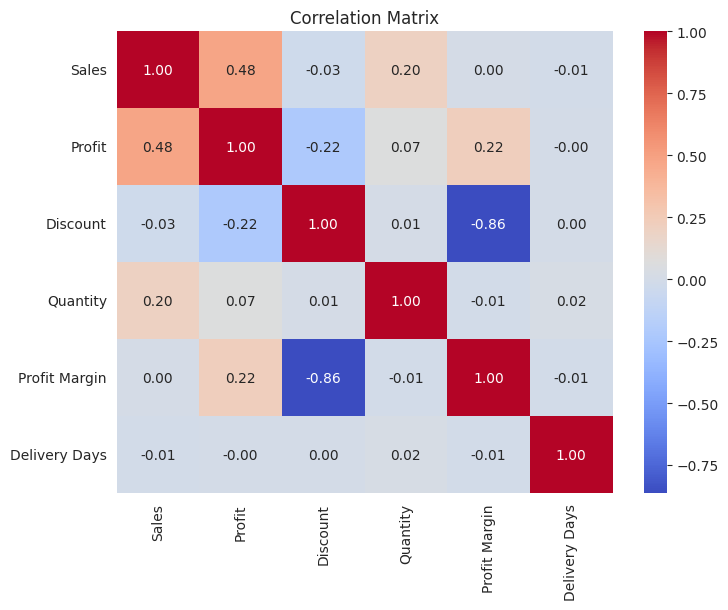

In [119]:
# Correlation heatmap
corr = superstore_df_raw[["Sales", "Profit", "Discount", "Quantity", "Profit Margin", "Delivery Days"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Shape: (9994, 24)

Dtypes:
 Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
Profit Margin           float64
Delivery Days             int64
Order Month               int32
dtype: object

Missing values (% of rows):
Series([], Name: Missing_%, dtype: float64)

Duplicate rows: 0
Duplicate 'Order ID's: 4985

Date coverage: 2014-01-03 → 2017-12-30
No zero-sales months detected 

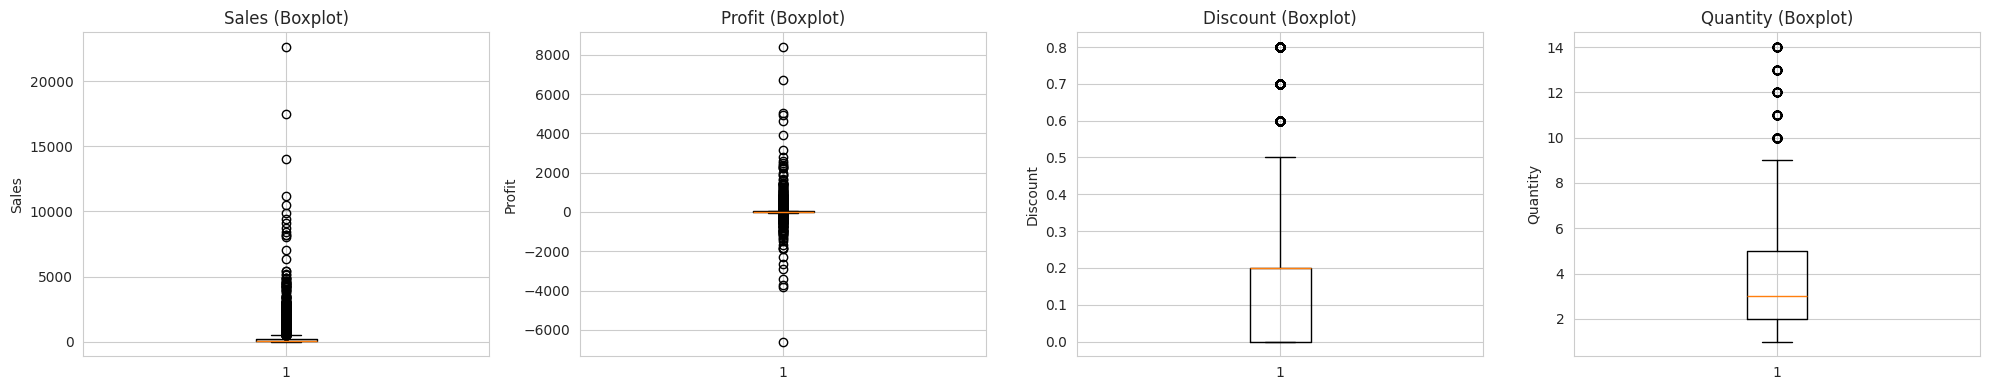

In [120]:
# Data Quality Check
df = superstore_df_raw.copy()

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)

num_cols = [c for c in ["Sales","Profit","Discount","Quantity","Shipping Cost"] if c in df.columns]

# 1) Data Quality Summary
# Missing values (%)
missing = (df.isna().mean().sort_values(ascending=False)*100).round(2).rename("Missing_%")
print(f"\nMissing values (% of rows):")
print(missing[missing>0])

# Duplicate rows & duplicate Order IDs
dup_rows = df.duplicated().sum()
dup_orders = df.duplicated(subset=["Order ID"]).sum() if "Order ID" in df.columns else np.nan
print(f"\nDuplicate rows: {dup_rows}")
if "Order ID" in df.columns:
    print(f"Duplicate 'Order ID's: {dup_orders}")

# Date coverage sanity check
if "Order Date" in df.columns:
    print(f"\nDate coverage: {df['Order Date'].min().date()} → {df['Order Date'].max().date()}")
    by_month = df.set_index("Order Date").resample("MS")["Sales"].sum()
    missing_months = by_month[by_month.eq(0)].index
    if len(missing_months):
        print(f"Months with zero recorded sales: {len(missing_months)}")
    else:
        print("No zero-sales months detected in monthly aggregation.")

# 2) Outlier Boxplots (Sales/Profit/Discount)
fig, axes = plt.subplots(1, len(num_cols), figsize=(5*len(num_cols), 4))
if len(num_cols)==1: axes = [axes]
for ax, col in zip(axes, num_cols):
    ax.boxplot(df[col].dropna(), vert=True)
    ax.set_title(f"{col} (Boxplot)")
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()


In [140]:
# Imputed missing values and capped Outliers
def missing_report(df):
    miss = df.isna().sum()
    pct = (miss / len(df) * 100).round(2)
    out = pd.DataFrame({"missing": miss, "missing_%": pct})
    return out[out["missing"] > 0].sort_values("missing_%", ascending=False)

def iqr_cap(s: pd.Series, factor: float = 1.5, hard_min=None, hard_max=None):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - factor * iqr, q3 + factor * iqr
    if hard_min is not None:
        low = max(low, hard_min)
    if hard_max is not None:
        high = min(high, hard_max)
    return s.clip(lower=low, upper=high)

superstore_df = superstore_df_raw.copy()

# 0) Basic cleaning
# Drop true duplicate rows
n_dupes_before = superstore_df.duplicated().sum()
superstore_df = superstore_df.drop_duplicates()
n_dupes_removed = n_dupes_before

# Parse dates & fix types
for c in ["Order Date", "Ship Date"]:
    if c in superstore_df.columns:
        superstore_df[c] = pd.to_datetime(superstore_df[c], errors="coerce")

# Numeric data
for c in ["Sales", "Profit", "Discount", "Quantity", "Postal Code"]:
    if c in superstore_df.columns:
        superstore_df[c] = pd.to_numeric(df[c], errors="coerce")

if {"Profit", "Sales"}.issubset(superstore_df.columns):
    # Avoid division by zero
    superstore_df["Profit Margin"] = np.where(df["Sales"] > 0, superstore_df["Profit"] / superstore_df["Sales"], np.nan)
if {"Ship Date", "Order Date"}.issubset(superstore_df.columns):
    superstore_df["Delivery Days"] = (superstore_df["Ship Date"] - superstore_df["Order Date"]).dt.days
if "Order Date" in superstore_df.columns:
    superstore_df["Order Year"] = superstore_df["Order Date"].dt.year
    superstore_df["Order Month"] = superstore_df["Order Date"].dt.month

# 1) Missing values (BEFORE view)
print("---- Missing values BEFORE ----")
miss_before = missing_report(superstore_df)
display(miss_before if not miss_before.empty else pd.DataFrame({"missing":[], "missing_%":[]}))

# 2) Imputations / drops
# If missing, drop the row
critical_keys = [c for c in ["Customer ID", "Order ID", "Order Date"] if c in superstore_df.columns]
superstore_df = superstore_df.dropna(subset=critical_keys)

# Categorical → mode
for c in ["Category", "Sub-Category", "Segment", "Ship Mode", "Country", "State", "City"]:
    if c in superstore_df.columns and superstore_df[c].isna().any():
        superstore_df[c] = superstore_df[c].fillna(superstore_df[c].mode().iloc[0])

# Numeric → median (robust) | Discount → 0 (no discount)
if "Discount" in superstore_df.columns:
    superstore_df["Discount"] = superstore_df["Discount"].fillna(0)

for c in ["Sales", "Profit", "Quantity", "Profit Margin", "Delivery Days", "Postal Code"]:
    if c in superstore_df.columns and superstore_df[c].isna().any():
        superstore_df[c] = superstore_df[c].fillna(superstore_df[c].median())

# 3) Outlier handling (IQR winsorization per field)
num_cols = [c for c in ["Sales", "Profit", "Profit Margin", "Quantity", "Delivery Days"] if c in superstore_df.columns]

# Count outliers BEFORE capping
def outlier_count(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return int(((s < low) | (s > high)).sum())

outliers_before = {c: outlier_count(superstore_df[c].dropna()) for c in num_cols}

# Apply winsorization (with a few logical hard bounds)
for c in num_cols:
    hard_min = None
    hard_max = None
    if c == "Profit Margin":
        # margin can be negative; cap to a plausible band
        hard_min, hard_max = -1.0, 3.0
    if c == "Delivery Days":
        hard_min, hard_max = 0, 60  # unlikely >2 months for superstore
    superstore_df[c] = iqr_cap(superstore_df[c], factor=1.5, hard_min=hard_min, hard_max=hard_max)

# Count outliers AFTER capping
outliers_after = {c: outlier_count(superstore_df[c].dropna()) for c in num_cols}

# 4) Quality summary (AFTER)
print("\n---- Missing values AFTER ----")
miss_after = missing_report(superstore_df)
display(miss_after if not miss_after.empty else pd.DataFrame({"missing":[], "missing_%":[]}))

print("\n---- Outliers (IQR) BEFORE vs AFTER ----")
outlier_tbl = pd.DataFrame({"before": outliers_before, "after": outliers_after})
display(outlier_tbl)

print("\n---- Row changes ----")
print(f"Duplicates removed: {n_dupes_removed}")
print(f"Final shape: {superstore_df.shape}")

#  Quick sanity metrics
metrics = {}
if {"Order ID"}.issubset(superstore_df.columns):
    metrics["orders"] = superstore_df["Order ID"].nunique()
if {"Customer ID"}.issubset(superstore_df.columns):
    metrics["customers"] = superstore_df["Customer ID"].nunique()
if {"Sales"}.issubset(superstore_df.columns):
    metrics["avg_order_value"] = (superstore_df["Sales"].sum() / superstore_df["Order ID"].nunique()) if "Order ID" in superstore_df.columns else superstore_df["Sales"].mean()
    metrics["total_sales"] = superstore_df["Sales"].sum()
if {"Profit"}.issubset(superstore_df.columns):
    metrics["total_profit"] = superstore_df["Profit"].sum()

print("\n---- Final Metrics ----")
superstore_df[["Sales", "Profit", "Discount", "Quantity", "Profit Margin"]].describe()



---- Missing values BEFORE ----


,missing,missing_%



---- Missing values AFTER ----


,missing,missing_%



---- Outliers (IQR) BEFORE vs AFTER ----


,before,after
Sales,0,0
Profit,0,0
Profit Margin,783,0
Quantity,0,0
Delivery Days,0,0



---- Row changes ----
Duplicates removed: 0
Final shape: (9994, 25)

---- Final Metrics ----


,Sales,Profit,Discount,Quantity,Profit Margin
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,140.281105,16.068014,0.156203,3.753352,0.184045
std,168.804241,29.486488,0.206452,2.102557,0.235091
min,0.444000,-39.724125,0.000000,1.000000,-0.337500
25%,17.280000,1.728750,0.000000,2.000000,0.075000
50%,54.490000,8.666500,0.200000,3.000000,0.245918
75%,209.940000,29.364000,0.200000,5.000000,0.350000
max,498.930000,70.816875,0.800000,9.500000,0.500000


# Sales Performance Analysis

## Sales Trend Analysis

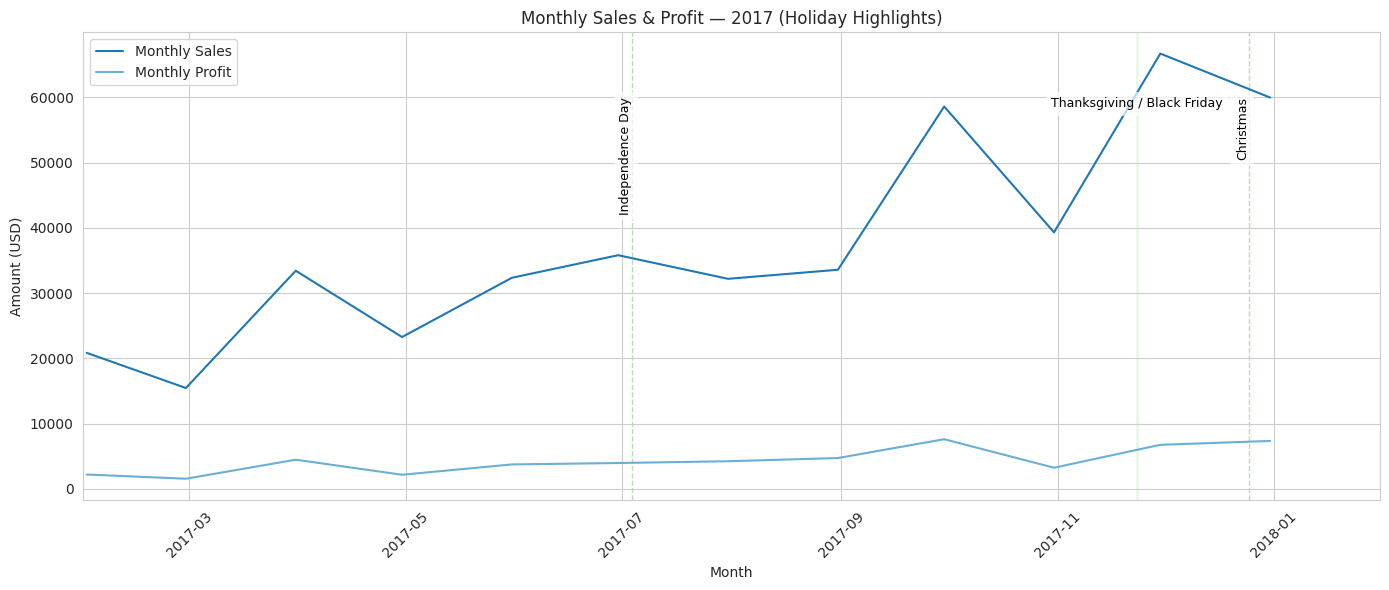

In [122]:
monthly = (
    superstore_df
    .set_index("Order Date")
    .resample("M")
    .agg(monthly_sales=("Sales", "sum"),
         monthly_profit=("Profit", "sum"))
    .reset_index()
)

# Thanksgiving
def thanksgiving(year: int) -> pd.Timestamp:
    thurs = pd.date_range(f"{year}-11-01", f"{year}-11-30", freq="W-THU")
    return thurs[3]  # 0,1,2,3 => 4th Thursday

# Slice to latest year for plotting

years = sorted(monthly["Order Date"].dt.year.unique())
latest_year = years[-1]
m_latest = monthly[monthly["Order Date"].dt.year == latest_year].copy()

# Holiday dates (this year)
tg   = thanksgiving(latest_year)
bf   = tg + pd.Timedelta(days=1)
xmas = pd.Timestamp(latest_year, 12, 25)
ny   = pd.Timestamp(latest_year, 1, 1)
indy = pd.Timestamp(latest_year, 7, 4)

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=m_latest, x="Order Date", y="monthly_sales", color="#1f77b4", label="Monthly Sales")
sns.lineplot(data=m_latest, x="Order Date", y="monthly_profit", color="#6baed6", label="Monthly Profit")

plt.title(f"Monthly Sales & Profit — {latest_year} (Holiday Highlights)")
plt.ylabel("Amount (USD)")
plt.xlabel("Month")
plt.xticks(rotation=45)

# Pad x-limits so holidays near edges are visible
xmin = m_latest["Order Date"].min() - pd.Timedelta(days=1)
xmax = m_latest["Order Date"].max() + pd.offsets.MonthEnd(1)
plt.xlim(xmin, xmax)

# (1) Single-day events: New Year, Independence Day, Christmas
single_day_holidays = [
    (ny,   "New Year"),
    (indy, "Independence Day"),
    (xmas, "Christmas"),
]
for date, label in single_day_holidays:
    if xmin <= date <= xmax:
        plt.axvline(date, linestyle="--", color="#a1d99b", alpha=0.8, linewidth=1, zorder=0)
        # small offset box for readability
        plt.text(date, m_latest["monthly_sales"].max()*0.9, label,
                 rotation=90, ha="right", va="top", fontsize=9, color="black",
                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# (2) Thanksgiving → Black Friday as a shaded band + single, centered label
if xmin <= tg <= xmax:
    plt.axvspan(tg, bf, facecolor="#a1d99b", alpha=0.2, linewidth=0, zorder=0)
    mid = tg + (bf - tg)/2
    plt.text(mid, m_latest["monthly_sales"].max()*0.9,
             "Thanksgiving / Black Friday",
             ha="center", va="top", fontsize=9, color="black",
             bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

plt.legend()
plt.tight_layout()
plt.show()


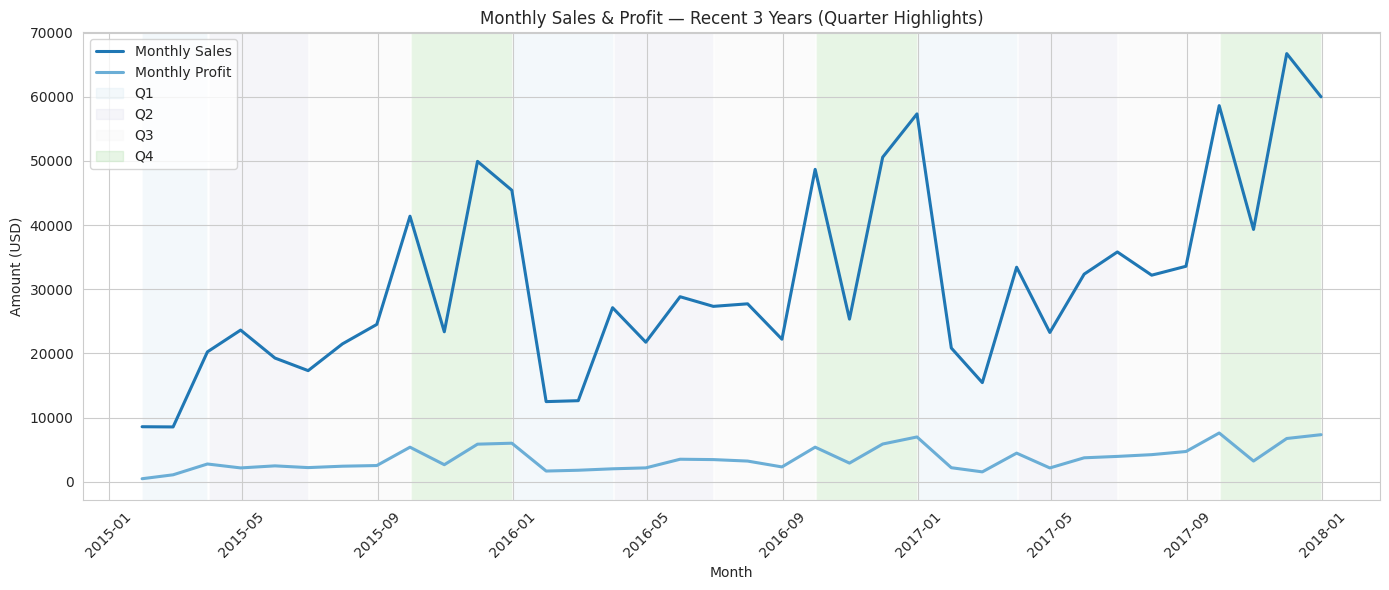

In [123]:
import matplotlib.patches as mpatches

# Choose recent 3 years
years = sorted(monthly["Order Date"].dt.year.unique())
recent_years = years[-3:] if len(years) >= 3 else years
m_recent = monthly[monthly["Order Date"].dt.year.isin(recent_years)].copy()

# Brand colors for lines
colors = {
    "sales":  "#1f77b4",  # dark blue
    "profit": "#6baed6",  # light blue
}

# Distinct quarter highlight colors
q_colors = {
    "Q1": "#d1e5f0",   # light blue
    "Q2": "#dadaeb",   # light purple
    "Q3": "#f2f2f2",   # light gray
    "Q4": "#a1d99b",   # softened green
}

plt.figure(figsize=(14,6))

# Lines
sns.lineplot(data=m_recent, x="Order Date", y="monthly_sales",
             label="Monthly Sales", color=colors["sales"], linewidth=2.2)
sns.lineplot(data=m_recent, x="Order Date", y="monthly_profit",
             label="Monthly Profit", color=colors["profit"], linewidth=2.2)

plt.title(f"Monthly Sales & Profit — Recent {len(recent_years)} Years (Quarter Highlights)")
plt.ylabel("Amount (USD)")
plt.xlabel("Month")
plt.xticks(rotation=45)

# Quarter shading
quarters = {"Q1": (1,3), "Q2": (4,6), "Q3": (7,9), "Q4": (10,12)}
for y in recent_years:
    for q, (m_start, m_end) in quarters.items():
        start = pd.Timestamp(y, m_start, 1)
        end   = pd.Timestamp(y, m_end, 1) + pd.offsets.MonthEnd(1)
        left  = max(start, m_recent["Order Date"].min())
        right = min(end,   m_recent["Order Date"].max())
        if left < right:
            plt.axvspan(left, right, facecolor=q_colors[q], alpha=0.25, zorder=0)

# Legend (lines first, then patches)
line_handles, line_labels = plt.gca().get_legend_handles_labels()
q_handles = [mpatches.Patch(color=c, alpha=0.25, label=q) for q,c in q_colors.items()]
plt.legend(handles=line_handles + q_handles, loc="upper left", title=None)

plt.tight_layout()
plt.show()

## Product & Category Analysis

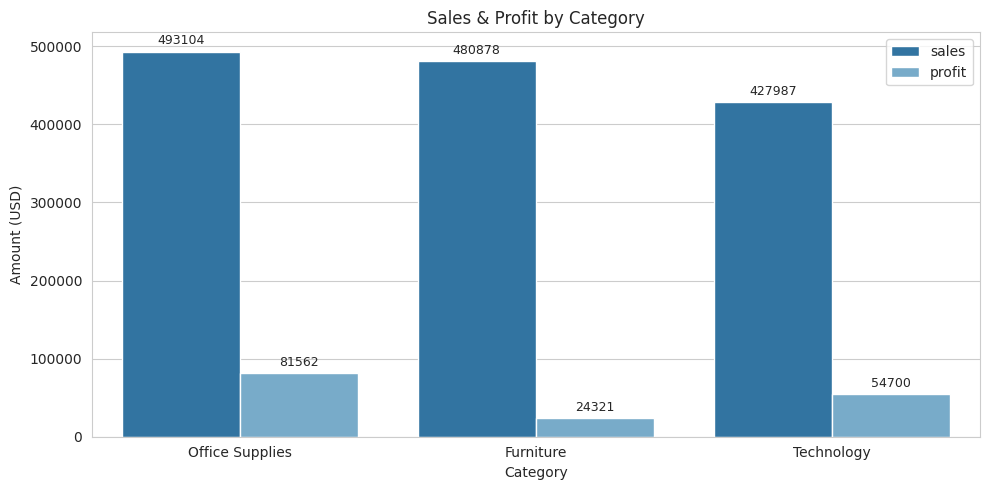

In [124]:
# Category Analysis
category_df = superstore_df.groupby('Category').agg(sales=('Sales', 'sum'), profit=('Profit', 'sum'), order=('Order ID', 'nunique')).reset_index()
category_df['margin'] = category_df['profit']/category_df['sales']
category_df = category_df.sort_values(by='sales', ascending=False)

# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=category_df.melt(id_vars="Category", value_vars=["sales","profit"]),
    x="Category", y="value", hue="variable",
    palette=["#1f77b4", "#6baed6"]
)

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", fontsize=9, padding=3)

plt.ylabel("Amount (USD)")
plt.title("Sales & Profit by Category")
plt.legend(title="")
plt.tight_layout()
plt.show()


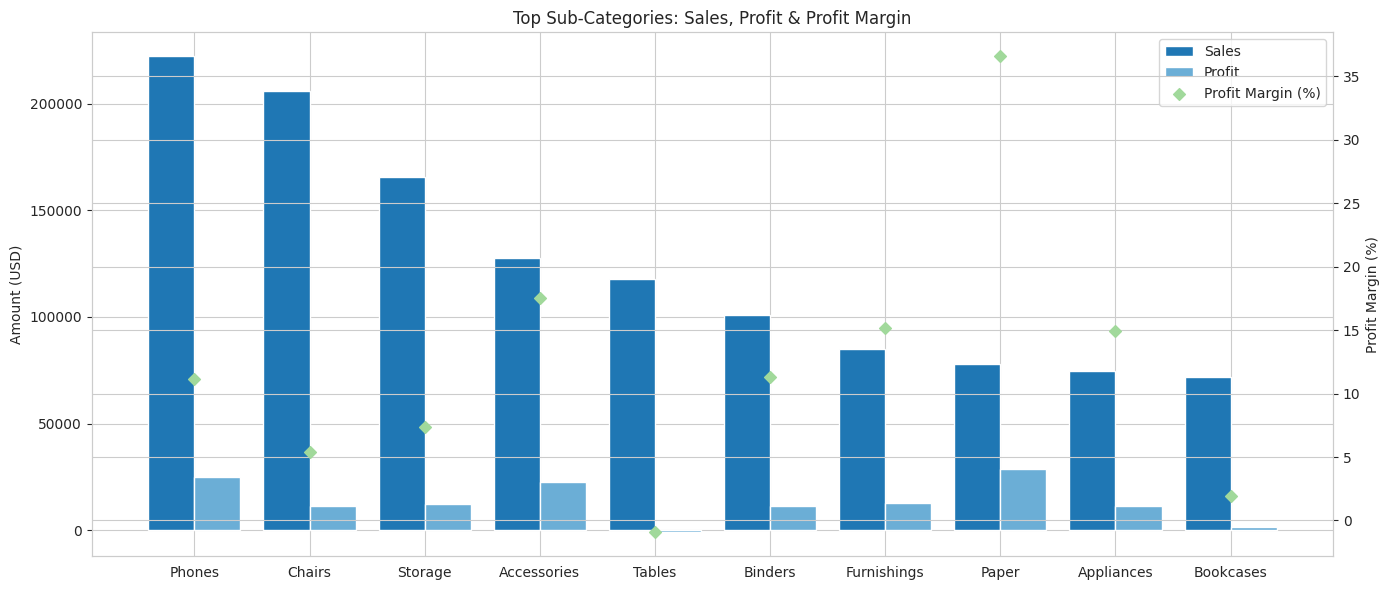

In [125]:
# Subcategory Analysis
subcat_sum = (
    superstore_df
    .groupby("Sub-Category", as_index=False)
    .agg(Sales=("Sales","sum"),
         Profit=("Profit","sum"),
         Orders=("Order ID","nunique"))
)
subcat_sum["Profit Margin"] = subcat_sum["Profit"] / subcat_sum["Sales"]
subcat_sum = subcat_sum.sort_values("Sales", ascending=False)

# Top 10 Sub-Categories by Sales
topN = 10
plot_sub = subcat_sum.head(topN).copy()
plot_sub["Profit Margin %"] = plot_sub["Profit Margin"] * 100

fig, ax1 = plt.subplots(figsize=(14,6))

# Bars: Sales and Profit
bar_width = 0.4
x = range(len(plot_sub))

ax1.bar([p - bar_width/2 for p in x], plot_sub["Sales"], width=bar_width, label="Sales", color="#1f77b4")
ax1.bar([p + bar_width/2 for p in x], plot_sub["Profit"], width=bar_width, label="Profit", color="#6baed6")
ax1.set_ylabel("Amount (USD)")

# Secondary axis: Profit Margin %
ax2 = ax1.twinx()
ax2.scatter(x, plot_sub["Profit Margin"]*100, color="#a1d99b", marker="D", label="Profit Margin (%)")
ax2.set_ylabel("Profit Margin (%)")

# X-axis labels
plt.xticks(x, plot_sub["Sub-Category"], rotation=45)
ax1.set_title("Top Sub-Categories: Sales, Profit & Profit Margin")

# Merge legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right")

plt.tight_layout()
plt.show()


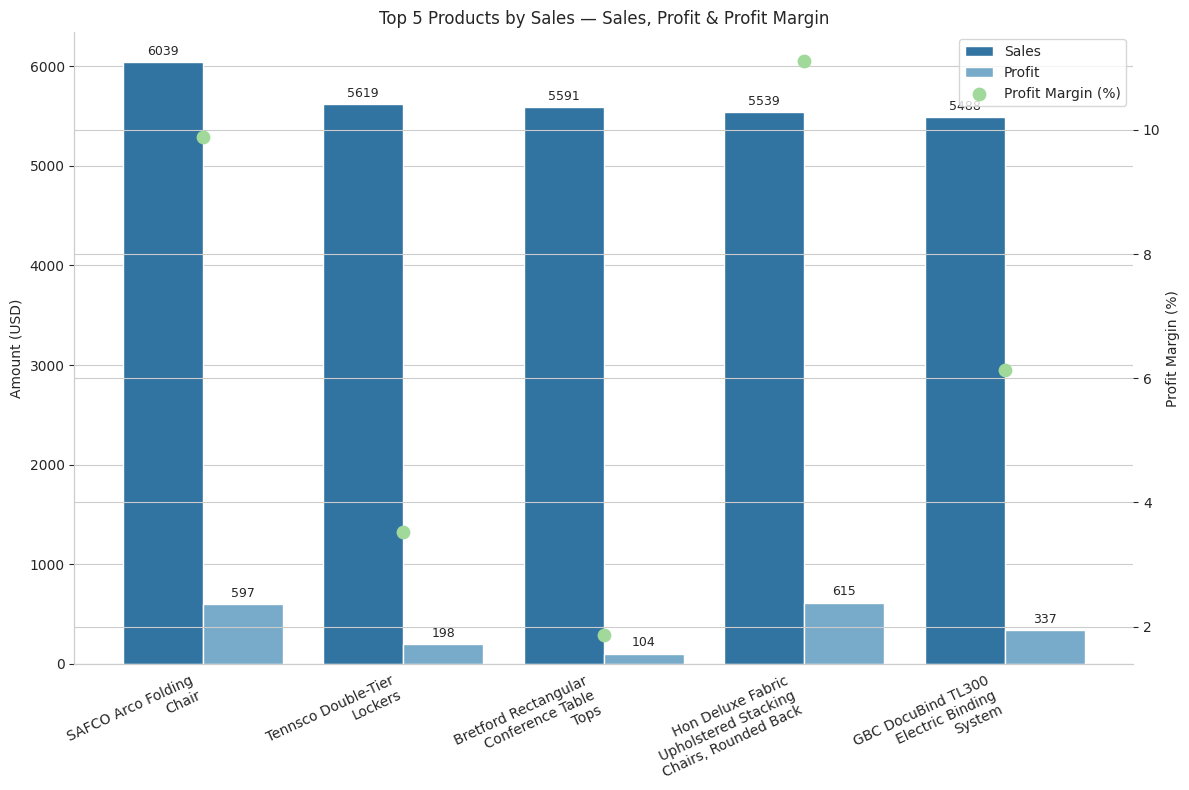

In [126]:
# Aggregate per product
prod_sum = (
    superstore_df
    .groupby("Product Name", as_index=False)
    .agg(Sales=("Sales","sum"),
         Profit=("Profit","sum"),
         Quantity=("Quantity","sum"))
)
prod_sum["Profit Margin"] = prod_sum["Profit"] / prod_sum["Sales"]

# Top 5 by Sales (already calculated)
top5_sales = prod_sum.sort_values("Sales", ascending=False).head(5)

# Wrap product names for readability
top5_sales["Product Short"] = top5_sales["Product Name"].str.wrap(20)

fig, ax1 = plt.subplots(figsize=(12,8))
sns.barplot(
    data=top5_sales.melt(id_vars="Product Short", value_vars=["Sales","Profit"]),
    x="Product Short", y="value", hue="variable",
    palette=[colors["sales"], colors["profit"]], ax=ax1
)

ax1.set_ylabel("Amount (USD)")
ax1.set_xlabel("")
ax1.set_title("Top 5 Products by Sales — Sales, Profit & Profit Margin")
plt.xticks(rotation=25, ha="right")

# Add numeric labels
for container in ax1.containers:
    ax1.bar_label(container, fmt="%.0f", fontsize=9, padding=3)

# Profit Margin as dots
ax2 = ax1.twinx()
ax2.scatter(top5_sales["Product Short"], top5_sales["Profit Margin"]*100,
            color="#a1d99b", marker="o", s=80, label="Profit Margin (%)")
ax2.set_ylabel("Profit Margin (%)")

# Merge legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right")

sns.despine()
plt.tight_layout()
plt.show()



## Region & Segment Analysis

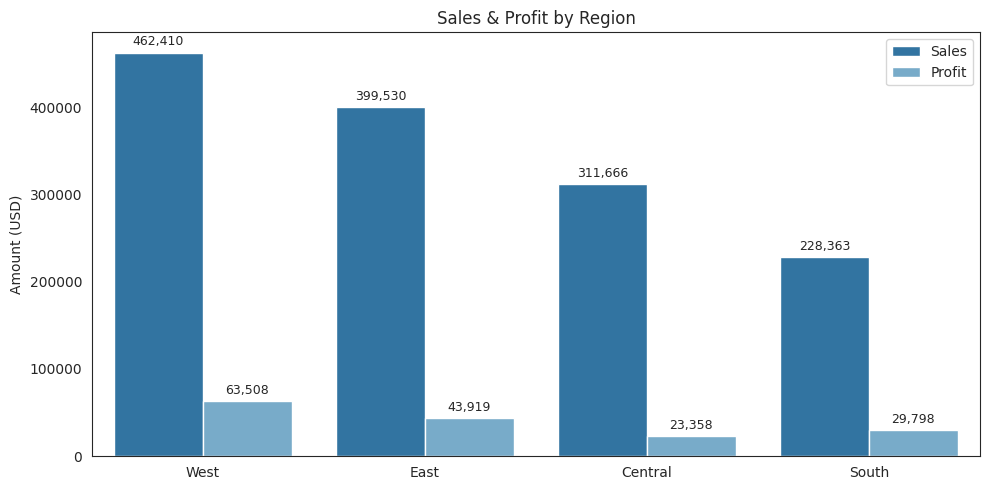

In [127]:

sns.set_style("white")
colors = {"sales":"#1f77b4", "profit":"#6baed6"}  # theme blues

# --- aggregate
region_df = (
    superstore_df
    .groupby("Region", as_index=False)
    .agg(Sales=("Sales","sum"), Profit=("Profit","sum"))
    .sort_values("Sales", ascending=False)
)

# --- plot: bars (Sales & Profit) + margin dots
fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(
    data=region_df.melt(id_vars="Region", value_vars=["Sales","Profit"]),
    x="Region", y="value", hue="variable",
    palette=[colors["sales"], colors["profit"]], ax=ax1
)
ax1.set_ylabel("Amount (USD)"); ax1.set_xlabel("")
ax1.set_title("Sales & Profit by Region"); ax1.legend(title="")

# labels on bars
for cont in ax1.containers:
    ax1.bar_label(cont, labels=[f"{b.get_height():,.0f}" for b in cont], padding=3, fontsize=9)

# merge legends
h1,l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc="upper right")

plt.tight_layout(); plt.show()


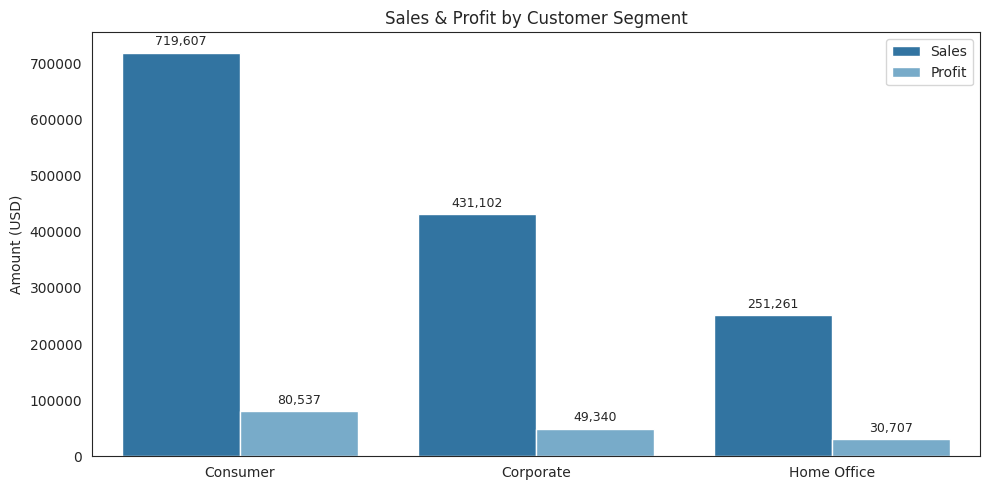

In [128]:
segment_df = (
    superstore_df
    .groupby("Segment", as_index=False)
    .agg(Sales=("Sales","sum"), Profit=("Profit","sum"))
    .sort_values("Sales", ascending=False)
)
segment_df["Profit Margin"] = segment_df["Profit"] / segment_df["Sales"]

fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(
    data=segment_df.melt(id_vars="Segment", value_vars=["Sales","Profit"]),
    x="Segment", y="value", hue="variable",
    palette=[colors["sales"], colors["profit"]], ax=ax1
)
ax1.set_ylabel("Amount (USD)"); ax1.set_xlabel("")
ax1.set_title("Sales & Profit by Customer Segment"); ax1.legend(title="")

for cont in ax1.containers:
    ax1.bar_label(cont, labels=[f"{b.get_height():,.0f}" for b in cont], padding=3, fontsize=9)

h1,l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc="upper right")

plt.tight_layout(); plt.show()


## Discount Analysis

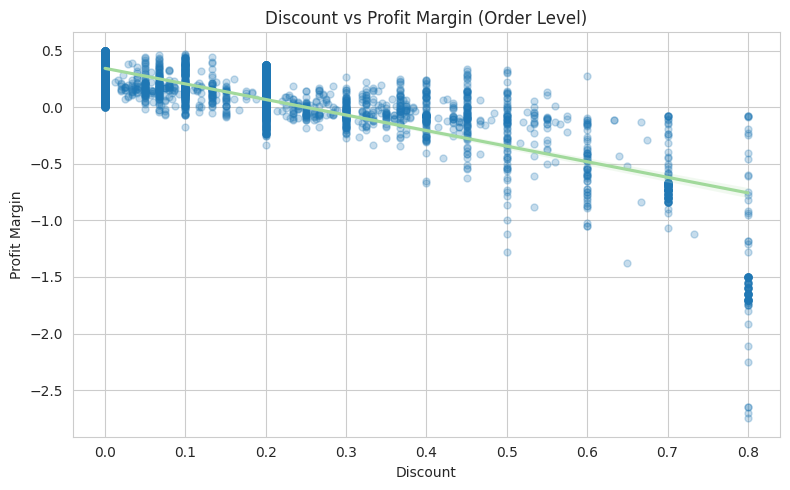

Correlation(Discount, Profit Margin) = -0.79


In [129]:
sns.set_style("whitegrid")
colors = {"sales":"#1f77b4", "profit":"#6baed6"}

df = superstore_df.copy()
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"]  = pd.to_datetime(df["Ship Date"])

order_df = (
    df.groupby("Order ID", as_index=False)
      .agg(Order_Date=("Order Date","min"),
           Sales=("Sales","sum"),
           Profit=("Profit","sum"),
           Discount=("Discount","mean"))      # average discount across lines
)
order_df["Profit_Margin"] = order_df["Profit"] / order_df["Sales"]

plt.figure(figsize=(8,5))
ax = sns.regplot(data=order_df, x="Discount", y="Profit_Margin",
                 scatter_kws={"alpha":0.25, "s":25},
                 line_kws={"color":"#a1d99b"})
ax.set_title("Discount vs Profit Margin (Order Level)")
ax.set_xlabel("Discount")
ax.set_ylabel("Profit Margin")
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
plt.tight_layout(); plt.show()

r = order_df[["Discount","Profit_Margin"]].corr().iloc[0,1]
print(f"Correlation(Discount, Profit Margin) = {r:.2f}")


# Marketing Analysis

## RFM

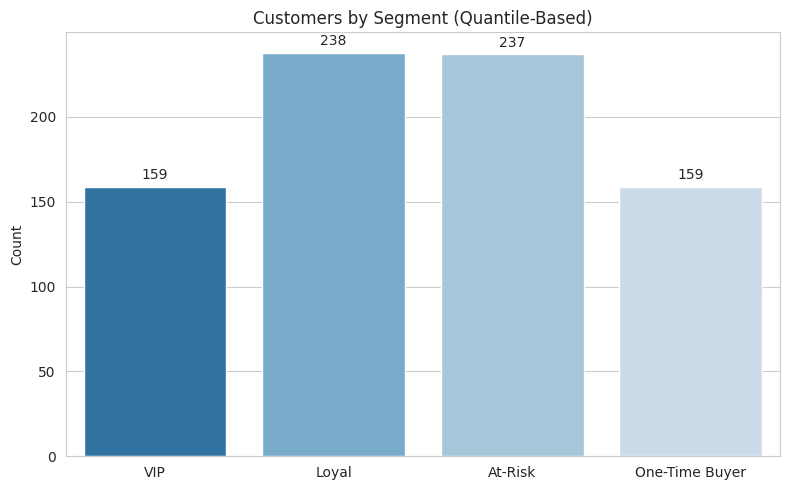

In [130]:
# Define reference date = max order date + 1 day (analysis snapshot)
snapshot_date = superstore_df["Order Date"].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics per customer
rfm = (
    superstore_df.groupby("Customer ID", as_index=False)
    .agg(
        Recency=("Order Date", lambda x: (snapshot_date - x.max()).days),
        Frequency=("Order ID", "nunique"),
        Monetary=("Sales", "sum")
    )
)

# Convert R/F/M to percentile scores (0–1)
#    Recency is inverted because lower days = better
rfm["R_pct"] = 1 - rfm["Recency"].rank(pct=True)      # good = recent
rfm["F_pct"] = rfm["Frequency"].rank(pct=True)        # good = many orders
rfm["M_pct"] = rfm["Monetary"].rank(pct=True)         # good = high spend

# Weighted composite score (tune weights as needed)
wR, wF, wM = 0.4, 0.3, 0.3
rfm["RFM_Composite"] = (wR*rfm["R_pct"] + wF*rfm["F_pct"] + wM*rfm["M_pct"]) * 100

# Quantile-based tiers: 20% / 30% / 30% / 20%
q20, q50, q80 = rfm["RFM_Composite"].quantile([0.20, 0.50, 0.80])

def tier(x):
    if x >= q80:            # top 20%
        return "VIP"
    elif x >= q50:          # next 30%
        return "Loyal"
    elif x >= q20:          # next 30%
        return "At-Risk"
    else:                   # bottom 20%
        return "One-Time Buyer"

rfm["Segment"] = rfm["RFM_Composite"].apply(tier)

# vic
order = ["VIP","Loyal","At-Risk","One-Time Buyer"]

plt.figure(figsize=(8,5))
ax = sns.countplot(
    data=rfm, x="Segment", order=order,
    palette=["#1f77b4","#6baed6","#9ecae1","#c6dbef"]
)
ax.set_title("Customers by Segment (Quantile-Based)")
ax.set_xlabel(""); ax.set_ylabel("Count")

for container in ax.containers:
    ax.bar_label(container, fmt="{:,.0f}", padding=3, fontsize=10, label_type="edge")

plt.tight_layout(); plt.show()
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=8, xytext=(0,2),
                textcoords="offset points")


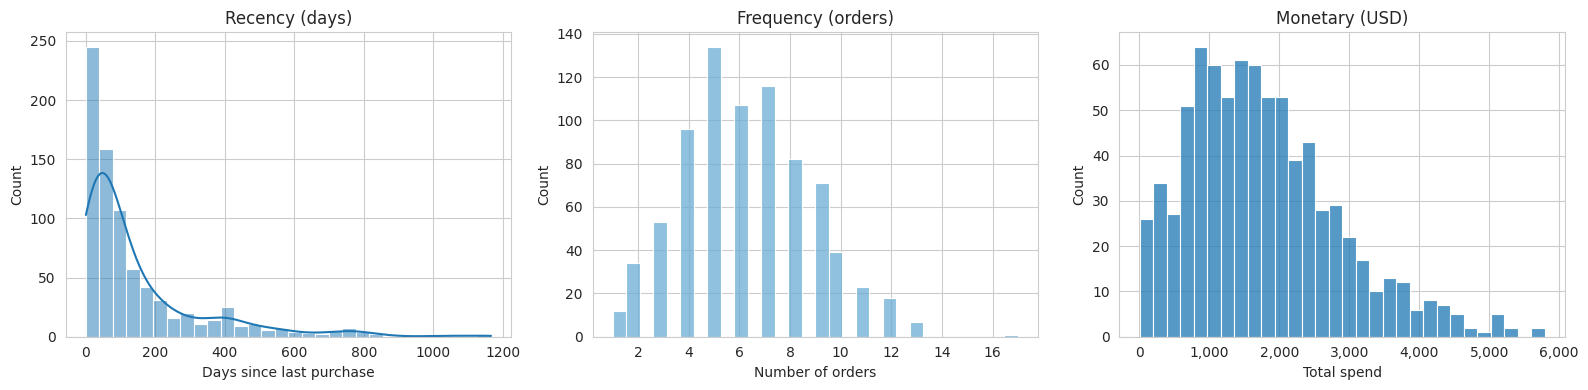

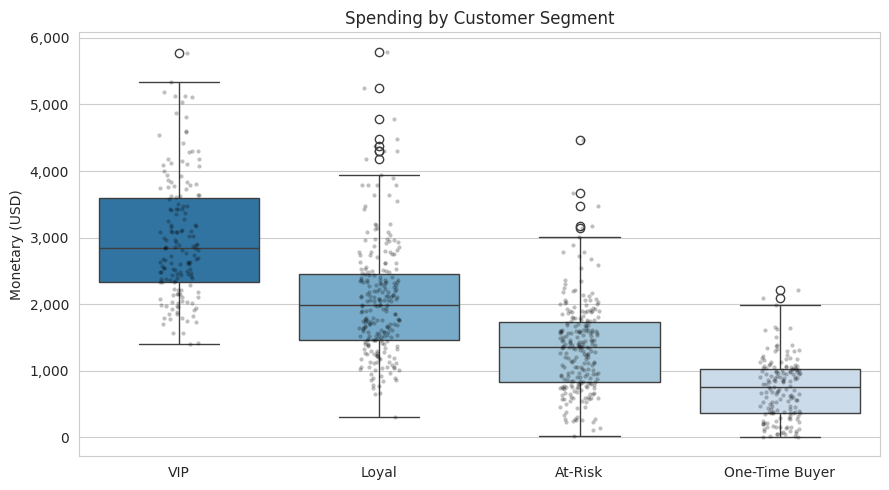

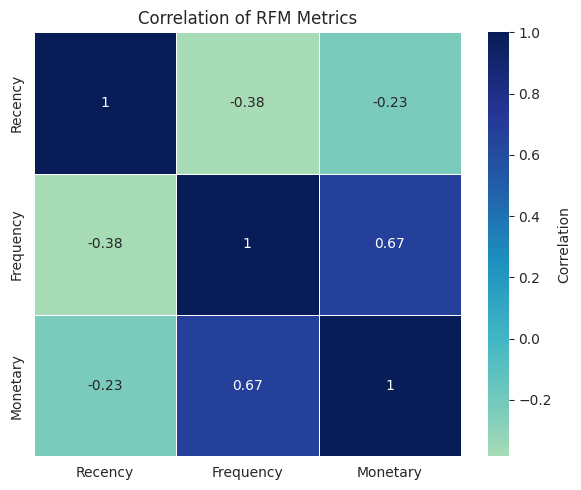

In [131]:
# Histograms: Recency, Frequency, Monetary
fig, axes = plt.subplots(1, 3, figsize=(16,4))

sns.histplot(rfm["Recency"],   bins=30, kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Recency (days)")
axes[0].set_xlabel("Days since last purchase")

sns.histplot(rfm["Frequency"], bins=30, kde=False, ax=axes[1], color="#6baed6")
axes[1].set_title("Frequency (orders)")
axes[1].set_xlabel("Number of orders")

sns.histplot(rfm["Monetary"],  bins=30, kde=False, ax=axes[2], color="#1f77b4")
axes[2].set_title("Monetary (USD)")
axes[2].set_xlabel("Total spend")
axes[2].get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

#  2) Boxplots: Spending behavior by customer tier
order = ["VIP", "Loyal", "At-Risk", "One-Time Buyer"]

fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(data=rfm, x="Segment", y="Monetary", order=order, palette=["#1f77b4","#6baed6","#9ecae1","#c6dbef"], ax=ax)
sns.stripplot(data=rfm, x="Segment", y="Monetary", order=order, color="black", alpha=0.25, size=3, ax=ax)
ax.set_title("Spending by Customer Segment")
ax.set_xlabel(""); ax.set_ylabel("Monetary (USD)")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout(); plt.show()

# Heatmap: RFM metric correlations
corr = rfm[["Recency","Frequency","Monetary"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr,
            annot=True,
            cmap="YlGnBu",   # blue-green palette
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'})
plt.title("Correlation of RFM Metrics")
plt.tight_layout()
plt.show()



In [132]:
# Summarize behavior by RFM Segment
rfm_behavior = (
    rfm.groupby("Segment")
       .agg(
           Customers=("Customer ID", "nunique"),
           Avg_Orders=("Frequency", "mean"),
           Avg_Spend=("Monetary", "mean"),
           Avg_Recency=("Recency", "mean"),
           Total_Spend=("Monetary", "sum")
       )
       .reset_index()
)

# Sort in logical order
order = ["VIP", "Loyal", "At-Risk", "One-Time Buyer"]
rfm_behavior["Segment"] = pd.Categorical(rfm_behavior["Segment"], categories=order, ordered=True)
rfm_behavior = rfm_behavior.sort_values("Segment")

rfm_behavior


,Segment,Customers,Avg_Orders,Avg_Spend,Avg_Recency,Total_Spend
3,VIP,159,9.207547,2980.662660,29.761006,473925.3629
1,Loyal,238,7.222689,2066.034232,72.516807,491716.1471
0,At-Risk,237,5.341772,1347.090795,151.118143,319260.5184
2,One-Time Buyer,159,3.522013,736.272560,373.591195,117067.3370


## Customer Segmentation using Kmeans



In [133]:
# Prepare dataset for segmentation - RFM features, shopping behavior, category they bought
df = superstore_df.copy()
df["Order Date"] = pd.to_datetime(df["Order Date"])

# Reference date for Recency
snapshot_date = df["Order Date"].max() + pd.Timedelta(days=1)

# Base per-customer RFM + behavioral features
cust = (
    df.assign(OrderMonth=df["Order Date"].dt.to_period("M"))
      .groupby("Customer ID", as_index=False)
      .agg(
          last_order=("Order Date", "max"),
          Orders=("Order ID", "nunique"),
          Monetary=("Sales", "sum"),
          Profit=("Profit", "sum"),
          Qty=("Quantity", "mean"),
          DiscountRate=("Discount", "mean")
      )
)
cust["Recency"] = (snapshot_date - cust["last_order"]).dt.days
cust["Avg_Order_Value"] = cust["Monetary"] / cust["Orders"]
cust["Profit_Margin"] = np.where(cust["Monetary"] > 0, cust["Profit"] / cust["Monetary"], 0)

# Frequency per active month
active_months = (
    df.assign(OrderMonth=df["Order Date"].dt.to_period("M"))
      .groupby("Customer ID")["OrderMonth"].nunique()
      .rename("ActiveMonths")
      .reset_index()
)
cust = cust.merge(active_months, on="Customer ID", how="left")
cust["Freq_per_Month"] = cust["Orders"] / cust["ActiveMonths"].clip(lower=1)

# Category mix (spend share by top 3 categories)
cat_share = (
    df.groupby(["Customer ID", "Category"], as_index=False)["Sales"].sum()
      .pivot_table(index="Customer ID", columns="Category", values="Sales", fill_value=0)
)
cat_tot = cat_share.sum(axis=1).replace(0, np.nan)
cat_share = cat_share.div(cat_tot, axis=0).fillna(0)  # percentages
for c in cat_share.columns:
    cat_share = cat_share.rename(columns={c: f"Share_{c.replace(' ', '')}"})

# Join features
features = cust.merge(cat_share.reset_index(), on="Customer ID", how="left")
num_cols = [
    "Recency","Orders","Monetary","Profit","Qty","DiscountRate",
    "Avg_Order_Value","Profit_Margin","ActiveMonths","Freq_per_Month"
] + [c for c in features.columns if c.startswith("Share_")]
features[num_cols] = features[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

features.head(3)


,Customer ID,last_order,Orders,Monetary,Profit,Qty,DiscountRate,Recency,Avg_Order_Value,Profit_Margin,ActiveMonths,Freq_per_Month,Share_Furniture,Share_OfficeSupplies,Share_Technology
0,AA-10315,2017-06-29,5,1957.780,181.718525,2.727273,0.090909,185,391.556,0.092819,5,1.0,0.007437,0.750607,0.241956
1,AA-10375,2017-12-11,9,1055.340,233.203875,2.733333,0.080000,20,117.260,0.220975,9,1.0,0.026911,0.247371,0.725719
2,AA-10480,2017-04-15,4,1790.512,315.746550,3.000000,0.016667,260,447.628,0.176344,4,1.0,0.265455,0.349214,0.385331


In [134]:
# Build Kmeans model
# Scale the data
X = features[num_cols].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Try a few K's and pick the one with best silhouette
sil = {}
for k in [3,4,5,6]:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Xs)
    sil[k] = silhouette_score(Xs, labels)
best_k = max(sil, key=sil.get)
print("best k:", best_k)

# Fit final KMeans with chosen K
km = KMeans(n_clusters=best_k, n_init=50, random_state=42)
features["Cluster"] = km.fit_predict(Xs)

best k: 3


### Explanation

*   In the above section, I found the **optimal number of clusters (k=5)**.  
*   In the section below, I assign business-friendly labels based on key behavioral and spending patterns to these clusters to better understand customer profiles.




In [135]:
# Cluster profiling on the original (unscaled) metrics
profile = (
    features.groupby("Cluster")[num_cols]
            .agg(["mean","median"])
            .round(2)
)
key_cols = ["Recency","Orders","Monetary","Avg_Order_Value","DiscountRate","Profit_Margin","Freq_per_Month",
            "Share_Furniture","Share_OfficeSupplies","Share_Technology"]
cluster_means = features.groupby("Cluster")[key_cols].mean().round(2)
cluster_sizes = features["Cluster"].value_counts().rename("Customers")

pd.concat([cluster_sizes, cluster_means], axis=1).sort_index()

# Normalize a few signals for rule thresholds
q = features.groupby("Cluster")[["Recency","Orders","Monetary","Avg_Order_Value","DiscountRate","Profit_Margin","Freq_per_Month"]].mean()

def label_cluster(row):
    # Lower Recency is better (more recent)
    recent = row["Recency"] <= q["Recency"].median()
    high_orders = row["Orders"] >= q["Orders"].median()
    high_spend = row["Monetary"] >= q["Monetary"].median()
    high_aov   = row["Avg_Order_Value"] >= q["Avg_Order_Value"].median()
    high_freq  = row["Freq_per_Month"] >= q["Freq_per_Month"].median()
    high_margin = row["Profit_Margin"] >= q["Profit_Margin"].median()
    high_disc = row["DiscountRate"] >= q["DiscountRate"].median()

    # Mapping rules
    if recent and high_orders and high_spend and high_margin:
        return "High-Value VIPs"
    if not recent and (not high_orders) and (not high_spend):
        return "At-Risk Office Buyers"
    if recent and (not high_orders) and high_aov:
        return "Tech Occasionals"
    if high_disc and (not high_spend) and (not high_orders):
        return "Price-Sensitive Light Buyers"
    # Fallbacks
    if high_orders and recent:
        return "Loyal Core"
    return "Mixed / Developing"

cluster_labels = {}
for c, row in q.iterrows():
    cluster_labels[c] = label_cluster(row)

cluster_labels

features["Segment_ML"] = features["Cluster"].map(cluster_labels)

# Final, business-friendly summary
summary = (
    features.groupby(["Cluster","Segment_ML"])
            .agg(
                Customers=("Customer ID","nunique"),
                Recency_days=("Recency","mean"),
                Orders=("Orders","mean"),
                Monetary_USD=("Monetary","mean"),
                AOV_USD=("Avg_Order_Value","mean"),
                DiscountRate=("DiscountRate","mean"),
                Profit_Margin=("Profit_Margin","mean"),
                Freq_per_Month=("Freq_per_Month","mean"),
                Share_Furniture=("Share_Furniture","mean"),
                Share_Office=("Share_OfficeSupplies","mean"),
                Share_Tech=("Share_Technology","mean"),
            )
            .round(2)
            .sort_index()
).reset_index()
summary


,Cluster,Segment_ML,Customers,Recency_days,Orders,Monetary_USD,AOV_USD,DiscountRate,Profit_Margin,Freq_per_Month,Share_Furniture,Share_Office,Share_Tech
0,0,Mixed / Developing,208,226.89,4.64,1268.97,285.98,0.22,0.04,1.05,0.51,0.30,0.19
1,1,Loyal Core,269,160.68,4.98,1039.16,217.92,0.12,0.17,1.08,0.17,0.49,0.34
2,2,High-Value VIPs,316,84.78,8.55,2716.74,328.11,0.15,0.12,1.11,0.35,0.33,0.31


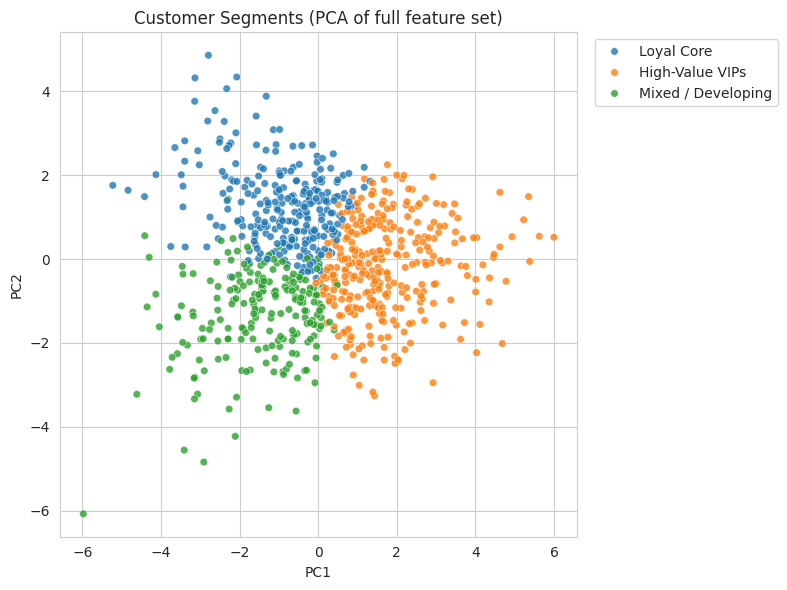

In [136]:
# Datapoint clustering visualization - PCA
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xs)

viz = features[["Customer ID","Cluster","Segment_ML"]].copy()
viz["PC1"], viz["PC2"] = Z[:,0], Z[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=viz, x="PC1", y="PC2", hue="Segment_ML", palette="tab10", s=30, alpha=0.8)
plt.title("Customer Segments (PCA of full feature set)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Market Basket Analysis

In [137]:
# Prepare transaction dataset (basket format: each row = order, each column = product category)
basket = (
    superstore_df.groupby(["Order ID","Category"])["Sales"]
                 .sum().unstack().fillna(0)
)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Frequent itemsets
frequent_items = apriori(basket, min_support=0.05, use_colnames=True)

# Association rules (confidence & lift)
rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by="lift", ascending=False)

display(rules.head(10))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,"(Office Supplies, Furniture)",(Technology),0.193452,0.308245,0.064684,0.334365,1.084738,1.0,0.005053,1.039241,0.096856,0.148013,0.037759,0.272105
2,(Technology),"(Office Supplies, Furniture)",0.308245,0.193452,0.064684,0.209845,1.084738,1.0,0.005053,1.020746,0.112928,0.148013,0.020325,0.272105
3,(Furniture),"(Technology, Office Supplies)",0.352166,0.182472,0.064684,0.183673,1.006587,1.0,0.000423,1.001472,0.010101,0.137638,0.001470,0.269080
0,"(Technology, Office Supplies)",(Furniture),0.182472,0.352166,0.064684,0.354486,1.006587,1.0,0.000423,1.003594,0.008004,0.137638,0.003581,0.269080
